## Makemore Part 5

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [48]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [49]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [84]:
from typing import Any


class Linear: 
    def __init__(self, fan_in: int, fan_out: int, bias: bool = True) -> None:
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self) -> list[torch.Tensor]:
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:

    def __init__(self, dim: int, eps: float = 1e-5, momentum: float = 0.1) -> None:
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(dim=dim, keepdim=True)
            xvar = x.var(dim=dim, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self) -> list[torch.Tensor]:
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        self.out = torch.tanh(x)
        return self.out
    def parameters(self) -> list[torch.Tensor]:
        return []
    
class Embedding:
    def __init__(self, num_embeddings, embedding_dim) -> None:
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX) ->  torch.Tensor:
        self.out = self.weight[IX]
        return self.out

    def parameters(self) -> list[torch.Tensor]:
        return [self.weight]

class FlattenConsecutive:
    def __init__(self, n: int) -> None:
        self.n = n
        
    def __call__(self, x) ->  torch.Tensor:
        B, T, C = x.shape # 32 x 8 x 10
        x = x.view(B, T//self.n, C*self.n) # 32 x 4 x 20
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out

    def parameters(self) -> list[torch.Tensor]:
        return []
    
class Sequential:
    def __init__(self, layers) -> None:
        self.layers = layers

    def __call__(self, x) -> Any:
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [85]:
torch.manual_seed(42); # seed rng for reproducibility

In [93]:
n_embd = 10
n_hidden = 68

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

22397


In [90]:
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  1, 26,  1, 18,  9,  1,  8],
        [ 0,  0,  1, 18, 18,  9,  5, 12],
        [ 0,  3,  1, 12,  5, 25,  1,  8]])

In [95]:
for layer in model.layers:
    print(layer.__class__.__name__, ":", tuple(layer.out.shape))

Embedding : (32, 8, 10)
FlattenConsecutive : (32, 4, 20)
Linear : (32, 4, 68)
BatchNorm1d : (32, 4, 68)
Tanh : (32, 4, 68)
FlattenConsecutive : (32, 2, 136)
Linear : (32, 2, 68)
BatchNorm1d : (32, 2, 68)
Tanh : (32, 2, 68)
FlattenConsecutive : (32, 136)
Linear : (32, 68)
BatchNorm1d : (32, 68)
Tanh : (32, 68)
Linear : (32, 27)


In [57]:
model.layers[0].out.shape

torch.Size([4, 8, 10])

In [58]:
model.layers[1].out.shape

torch.Size([4, 80])

In [59]:
model.layers[2].out.shape

torch.Size([4, 200])

In [65]:
(torch.randn(4, 4, 20) @ torch.randn(20, 200) + torch.randn(200)).shape

torch.Size([4, 4, 200])

In [63]:
model.layers[0].out.view(-1, 80).shape

torch.Size([4, 80])

In [64]:
model.layers[0].out.view(-1, 4, 20).shape

torch.Size([4, 4, 20])

In [94]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # Minibatch-Construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # Batch X,Y

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # Tracking stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3083


KeyboardInterrupt: 

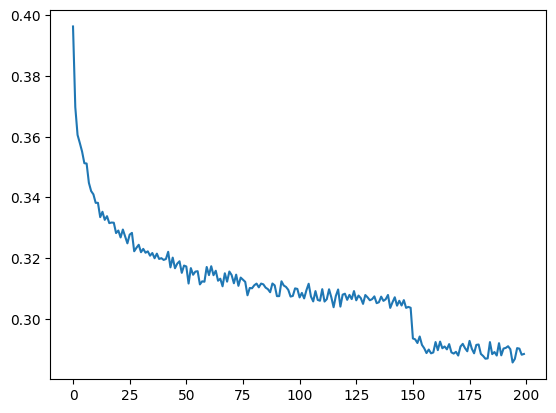

In [23]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(dim=1))

In [39]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [40]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 3.26682448387146
val 3.266975164413452


In [41]:
# sample from the model
for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

hnqquvsiniw.
fjqostoqgb.
yughmrzb.
xlmximkrydraaorihyeloqkqbqnuvtcczobyxvtbyewj.
hiofcnrtbruejkrgxternpbfuoxrzpvdhqs.
cgkxrpbujhghfzftaposbkltcsypshhwcqnqkqireniincoh.
koeuvd.
oxtkigcmudsxdjdygmawckllxiqbkxwyoyaeersmlbyzrzcxaycazewbmjldnrrrzcxltsgvrajeywdgzby.
rgetsjynujkijxjkctdvljhy.
ljwpobuxoqohzjprhepuwpsnzxxstmtbulqzg.
dio.
jwhexonrigmnwwnnq.
hotdzhhbhmrlkzexwvaercaocgrzztglykrukhznutdmhtkbocnscdxcogquauxmauvdteharmobacwdwinjoqftewt.
rexcpiwlrftxodlmolwz.
suylzbhmfpcykvkrjbusmyxacvsavrfdjrvrmbuswworvnhoncilrygduruiufchiqgrcpnjgasmhtwyixbtmtyzpdvydryfaimteyikcuqxxzmaiulbtwcqxlwyedg.
whjxxuwcswctij.
ildgpygcucjbtbtoxdg.
vriutxjh.
mqqjxqagrnybwhkudahvnxbjnqkvhrisuaeenamyuckxyptfxqhozvdzzhymxmfacqztjnxajstgskrlrjnpgb.
oqnifqfxxbwbcbucoetirpnc.
